In [1]:
#Compare the Difference in polling spreads between 2, 3, and 5 candidates using RealClearPolitics data
from selenium import webdriver
from bs4 import BeautifulSoup
import pandas as pd
import time
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import plotly.express as px

# Suppress a specific warning
warnings.simplefilter("ignore", category=FutureWarning)

In [2]:
#build urls
base_url = "https://www.realclearpolling.com/polls/"
two_candidate = "president/general/2024/trump-vs-biden"
three_candidate = "president/general/2024/trump-vs-biden-vs-kennedy"
five_candidate = "president/general/2024/trump-vs-biden-vs-kennedy-vs-west-vs-stein"
jbdturl = base_url + two_candidate
jbkturl = base_url + three_candidate
fivecanurl = base_url + five_candidate

In [3]:
#Function to get the data and load it into a dataframe

def get_poll_data(url):
    # Create a webdriver instance and get the page source
    driver = webdriver.Chrome()
    driver.get(url)
    time.sleep(3)

    # Get the page source after dynamic content has loaded
    html_content = driver.page_source

    # Close the webdriver
    driver.quit()

    # Parse the HTML content with BeautifulSoup
    soup = BeautifulSoup(html_content, 'html5lib')

    # Now you can extract the table data using the same approach as before
    table = soup.find_all('table')

    if len(table)==2:
        table = table[1]
    else:
        table = table[0]

    table_data = []
    for row in table.find_all('tr'):
        row_data = [cell.text.strip() for cell in row.find_all(['td','th'])]
        table_data.append(row_data)
    df = pd.DataFrame(table_data[2:], columns=table_data[0])
    return df 

jbdt = get_poll_data(jbdturl)
rfk = get_poll_data(jbkturl)
fivcan = get_poll_data(fivecanurl)

In [4]:
#Clean the data

def clean_data(df):
    df = df.copy()
    current_year = str(datetime.now().year)
    prev_year = str(datetime.now().year-1)
    df["Difference"] = df["Trump (R)"].astype(float) - df["Biden (D)"].astype(float)
    df["Type of Voter"] = df["sample"].str.split(" ").str[1]
    df["Sample Size"] = pd.to_numeric(df["sample"].str.split(" ").str[0], errors="coerce").fillna(0).astype(int)
    df["End Date"] = df["date"].str.split("-").str[1] 
    df["Poll Month"] = df["date"].str.split("-").str[1].str.split("/").str[0]
    df["Poll Month"] = df["Poll Month"].astype(int)
    first_dec = df[df["Poll Month"]==12].index[0]
    df["Year"] = [current_year]*first_dec + [prev_year]*(len(df)-first_dec)
    df["End Date"] = df["End Date"] + "/" + df["Year"]
    df["End Date"] = np.array(pd.to_datetime(df["End Date"], format="mixed"))
    df = df[df["Type of Voter"].isin(["RV", "LV"])]
    df["Biden (D)"] = df["Biden (D)"].astype(float)
    df["Trump (R)"] = df["Trump (R)"].astype(float)

    for can_name in ["Kennedy (I)", "West (I)", "Stein (G)"]:
        if can_name in df.columns:
            df[can_name] = df[can_name].astype(float)

    df["Days Since 01-01-23"] = (df["End Date"] - pd.to_datetime("01-01-23")).dt.days
    return df 

jbdt = clean_data(jbdt)
rfk = clean_data(rfk)
fivcan = clean_data(fivcan)

In [5]:
#Display two candidate data
jbdt.head()

,pollster,date,sample,moe,Trump (R),Biden (D),spread,Difference,Type of Voter,Sample Size,End Date,Poll Month,Year,Days Since 01-01-23
0,HarrisX**,2/20 - 2/22,3024 RV,1.8,52.0,48.0,Trump+4,4.0,RV,3024,2024-02-22,2,2024,417
1,Economist/YouGov,2/18 - 2/20,1360 RV,3.2,43.0,42.0,Trump+1,1.0,RV,1360,2024-02-20,2,2024,415
2,Morning Consult,2/17 - 2/19,6321 RV,1.0,45.0,41.0,Trump+4,4.0,RV,6321,2024-02-19,2,2024,414
3,Quinnipiac,2/15 - 2/19,1421 RV,2.6,45.0,49.0,Biden+4,-4.0,RV,1421,2024-02-19,2,2024,414
4,Rasmussen Reports,2/13 - 2/15,868 LV,3.0,47.0,41.0,Trump+6,6.0,LV,868,2024-02-15,2,2024,410


In [6]:
#Display three candidate data
rfk.head()

,pollster,date,sample,moe,Trump (R),Biden (D),Kennedy (I),spread,Difference,Type of Voter,Sample Size,End Date,Poll Month,Year,Days Since 01-01-23
0,Rasmussen Reports,2/13 - 2/15,868 LV,3.0,43.0,37.0,12.0,Trump+6,6.0,LV,868,2024-02-15,2,2024,410
2,Harvard-Harris,1/17 - 1/18,2346 RV,—,44.0,36.0,21.0,Trump+8,8.0,RV,2346,2024-01-18,1,2024,382
3,Reuters/Ipsos,1/3 - 1/9,4677 RV,1.5,30.0,29.0,18.0,Trump+1,1.0,RV,4677,2024-01-09,1,2024,373
4,Quinnipiac,12/14 - 12/18,1647 RV,2.4,36.0,38.0,22.0,Biden+2,-2.0,RV,1647,2023-12-18,12,2023,351
5,Harvard-Harris,12/13 - 12/14,2034 RV,2.0,44.0,36.0,20.0,Trump+8,8.0,RV,2034,2023-12-14,12,2023,347


In [7]:
#Display five candidate data
fivcan.head()

,pollster,date,sample,moe,Trump (R),Biden (D),Kennedy (I),West (I),Stein (G),spread,Difference,Type of Voter,Sample Size,End Date,Poll Month,Year,Days Since 01-01-23
0,HarrisX**,2/20 - 2/22,3024 RV,1.8,42.0,40.0,14.0,3.0,2.0,Trump+2,2.0,RV,3024,2024-02-22,2,2024,417
1,Quinnipiac,2/15 - 2/19,1421 RV,2.6,37.0,38.0,15.0,3.0,3.0,Biden+1,-1.0,RV,1421,2024-02-19,2,2024,414
2,HarrisX**,2/12 - 2/16,3024 RV,1.8,44.0,36.0,15.0,3.0,3.0,Trump+8,8.0,RV,3024,2024-02-16,2,2024,411
3,Emerson,2/13 - 2/14,1225 RV,2.7,40.0,38.0,7.0,1.0,1.0,Trump+2,2.0,RV,1225,2024-02-14,2,2024,409
4,Marquette,2/5 - 2/15,787 RV,4.5,42.0,39.0,15.0,3.0,2.0,Trump+3,3.0,RV,787,2024-02-15,2,2024,410


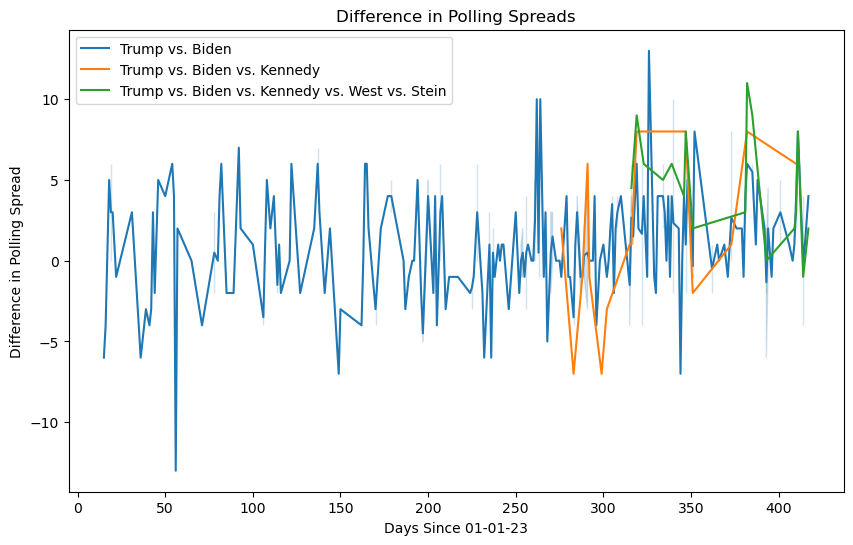

In [8]:
#Plot the difference in polling spreads for all three scenarios on the same plot
plt.figure(figsize=(10,6))
sns.lineplot(data=jbdt, x="Days Since 01-01-23", y="Difference", label="Trump vs. Biden")
sns.lineplot(data=rfk, x="Days Since 01-01-23", y="Difference", label="Trump vs. Biden vs. Kennedy")
sns.lineplot(data=fivcan, x="Days Since 01-01-23", y="Difference", label="Trump vs. Biden vs. Kennedy vs. West vs. Stein")
plt.title("Difference in Polling Spreads")
plt.xlabel("Days Since 01-01-23")
plt.ylabel("Difference in Polling Spread")
plt.legend()


In [ ]:
#